In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [23]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/DeepLearning_Final_Project_2024')
print(os.path.exists('./model_task_b_densenet121.pth'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
True


<ipython-input-4-5bb52bf165fc>:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location="cuda" if torch.cuda.is_available() el

Evaluating ResNet18...


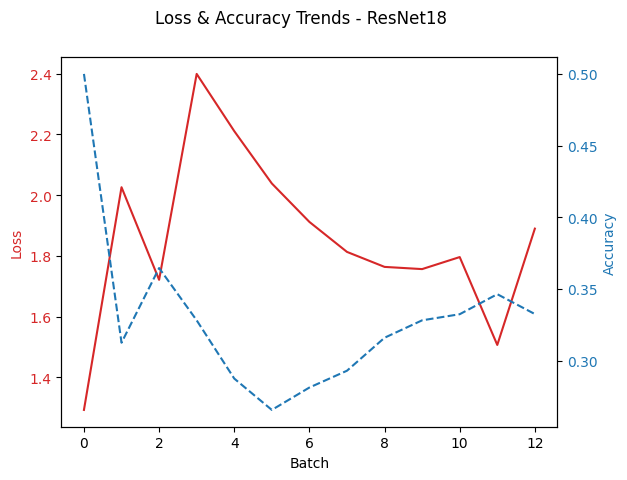

Evaluating Attention Model...


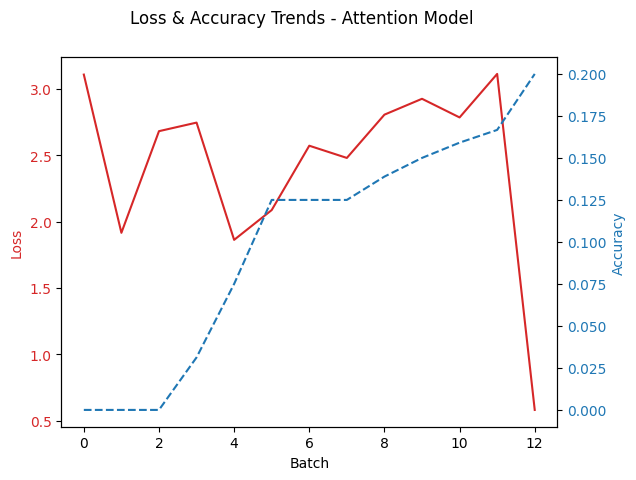

In [4]:
# ===========================
#  Dataset Class for Validation Set
# ===========================
class ValDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.labels = self.data['patient_DR_Level'].values  # True labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.data.iloc[index]['img_path'])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.labels[index]
        return image, label

# ===========================
#  Image Transformations
# ===========================
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ===========================
#  Load Trained Models
# ===========================
def load_model(checkpoint_path, model_type="resnet18"):
    """Load a trained model from checkpoint."""
    if model_type == "resnet18":
        model = models.resnet18(weights=None)
        model.fc = nn.Linear(512, 5)
    elif model_type == "attention":
        model = models.resnet18(weights=None)  # Replace with actual attention model architecture
        model.fc = nn.Linear(512, 5)  # Modify as per architecture
    else:
        raise ValueError("Invalid model type")

    state_dict = torch.load(checkpoint_path, map_location="cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    return model

# ===========================
#  Evaluate Model & Track Metrics
# ===========================
def evaluate_model(model, dataloader, device):
    """Evaluate the model on validation data and collect accuracy/loss trends."""
    model.to(device)
    criterion = nn.CrossEntropyLoss()

    total_samples = 0
    correct = 0
    loss_list = []
    accuracy_list = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)
            accuracy_list.append(correct / total_samples)

    return loss_list, accuracy_list

# ===========================
#  Plot Loss & Accuracy Trends
# ===========================
def plot_metrics(losses, accuracies, model_name):
    """Plot loss & accuracy curves for a given model."""
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Batch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(losses, color='tab:red', label="Loss")
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.plot(accuracies, color='tab:blue', linestyle='dashed', label="Accuracy")
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.suptitle(f'Loss & Accuracy Trends - {model_name}')
    plt.show()

# ===========================
#  Main Script
# ===========================
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load validation dataset
    val_dataset = ValDataset('./DeepDRiD/val.csv', './DeepDRiD/val/', transform_val)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Load models
    resnet18_model = load_model("./resnet18_best.pth", model_type="resnet18")
    attention_model = load_model("./attention_best.pth", model_type="attention")

    # Evaluate ResNet18
    print("Evaluating ResNet18...")
    resnet18_losses, resnet18_accuracies = evaluate_model(resnet18_model, val_loader, device)
    plot_metrics(resnet18_losses, resnet18_accuracies, "ResNet18")

    # Evaluate Attention Model
    print("Evaluating Attention Model...")
    attention_losses, attention_accuracies = evaluate_model(attention_model, val_loader, device)
    plot_metrics(attention_losses, attention_accuracies, "Attention Model")


In [26]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

def preprocess_image(img_path, transform):
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)
    return img_tensor, img

def get_grad_cam(model, img_tensor, target_layer):
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    hook_backward = target_layer.register_backward_hook(backward_hook)
    hook_forward = target_layer.register_forward_hook(forward_hook)

    model.eval()
    img_tensor.requires_grad_()
    output = model(img_tensor)

    class_idx = torch.argmax(output).item()
    model.zero_grad()
    output[0, class_idx].backward()

    gradients = gradients[0].detach().cpu().numpy()
    activations = activations[0].detach().cpu().numpy()

    pooled_gradients = np.mean(gradients, axis=(2, 3), keepdims=True)
    cam = np.sum(pooled_gradients * activations, axis=1)[0]
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)

    hook_backward.remove()
    hook_forward.remove()

    return cam

def overlay_heatmap(img, cam, alpha=0.4):
    """Overlay Grad-CAM heatmap onto the original image."""
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # 🔹 Resize original image to match Grad-CAM size (224x224)
    img = img.resize((224, 224))

    # 🔹 Ensure the image has 3 channels (convert grayscale to RGB if needed)
    img_array = np.array(img)
    if len(img_array.shape) == 2:  # If grayscale
        img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)

    # 🔹 Perform overlay
    overlay = cv2.addWeighted(img_array, alpha, heatmap, 1 - alpha, 0)
    return overlay

def visualize_grad_cam(model, img_path, target_layer):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    img_tensor, img = preprocess_image(img_path, transform)
    cam = get_grad_cam(model, img_tensor, target_layer)
    overlay_img = overlay_heatmap(img, cam)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay_img)
    plt.axis('off')
    plt.title("Grad-CAM Overlay")
    plt.show()

# Example Usage:
# model = torch.load('best_resnet18.pth')
# target_layer = model.layer4[1].conv2  # Choose last convolutional layer
# visualize_grad_cam(model, 'sample_image.jpg', target_layer)


In [27]:
print(os.path.exists('./sample_image.jpg'))


True


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-28-8900378b91cc>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

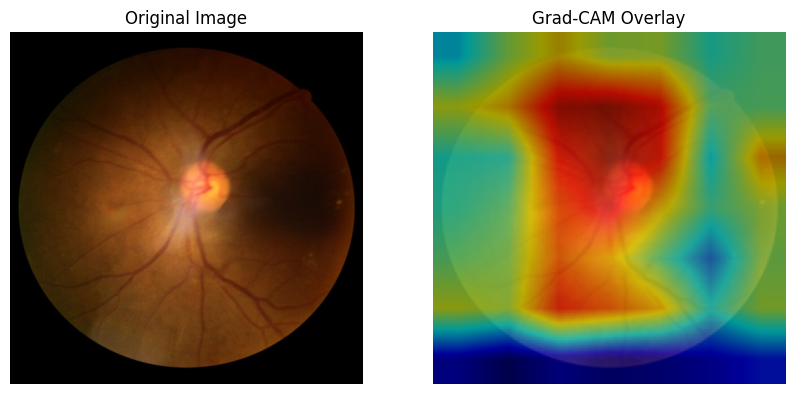

In [28]:

# Define the model architecture
model = models.resnet18(pretrained=False)  # Ensure the same architecture used for training

# Load the trained weights
state_dict = torch.load('./resnet18_best.pth', map_location="cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(state_dict, strict=False)

# Move the model to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set the model to evaluation mode

# Select the target convolutional layer for Grad-CAM
target_layer = model.layer4[1].conv2

# Run visualization
visualize_grad_cam(model, 'sample_image.jpg', target_layer)